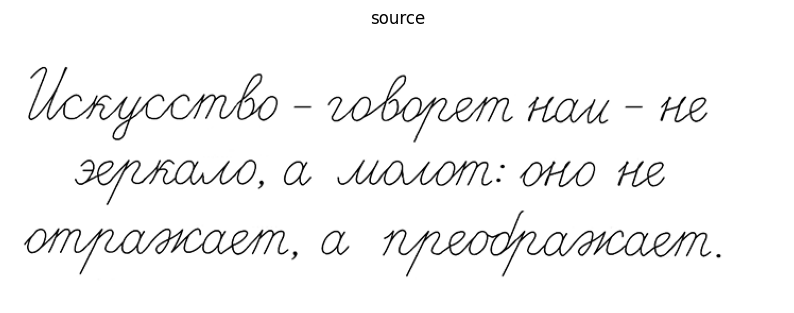

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("handwritten1.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,10))
plt.title("source")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


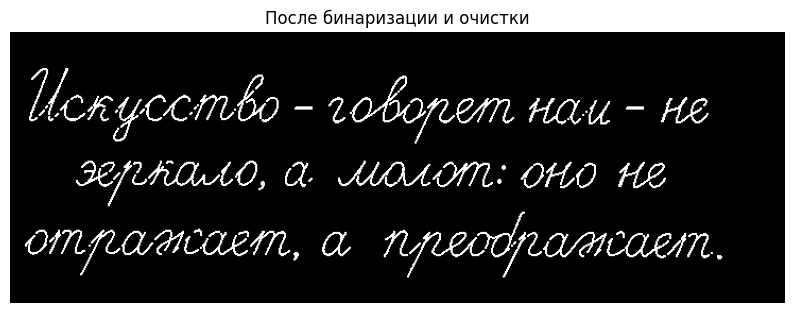

In [3]:
thr = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                            cv2.THRESH_BINARY_INV, 35, 15)

kernel = np.ones((2,2), np.uint8)
clean = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(10,10))
plt.title("После бинаризации и очистки")
plt.imshow(clean, cmap='gray')
plt.axis('off')
plt.show()


Amount of lines: 3


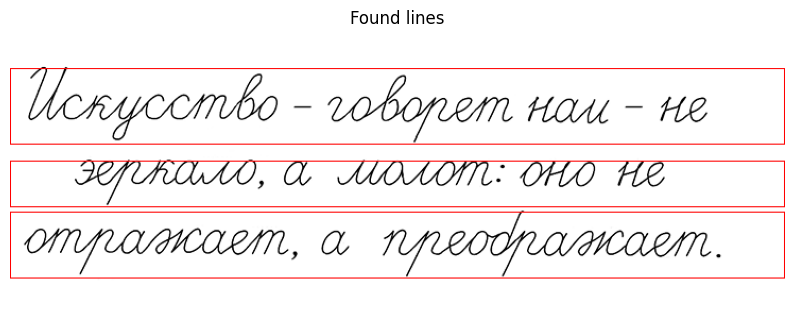

In [4]:
hist = clean.sum(axis=1)
lines = []
in_run = False
for y, v in enumerate(hist):
    if v > 0 and not in_run:
        y0 = y; in_run = True
    if v == 0 and in_run:
        lines.append((y0, y)); in_run = False
if in_run:
    lines.append((y0, clean.shape[0]-1))

print("Amount of lines:", len(lines))

color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for (y0, y1) in lines:
    cv2.rectangle(color, (0, y0), (color.shape[1]-1, y1), (0,0,255), 1)

plt.figure(figsize=(10,10))
plt.title("Found lines")
plt.imshow(color[..., ::-1])
plt.axis('off')
plt.show()


In [5]:
bboxes = []
for (y0, y1) in lines:
    row = clean[y0:y1, :]

    proj = row.sum(axis=0)
    gaps = np.diff(np.where((proj==0).astype(np.uint8)))
    k = int(np.median(gaps[gaps>0])) if len(gaps[gaps>0]) else 8
    k = max(4, min(30, k))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, 1))
    merged = cv2.morphologyEx(row, cv2.MORPH_CLOSE, kernel, iterations=1)

    n, labels, stats, _ = cv2.connectedComponentsWithStats(merged, connectivity=8)
    for i in range(1, n):
        x, y, w, h, area = stats[i]
        if h < 8 or area < 40:
            continue
        bboxes.append((x, y + y0, w, h))

print("Found words:", len(bboxes))


Found words: 38


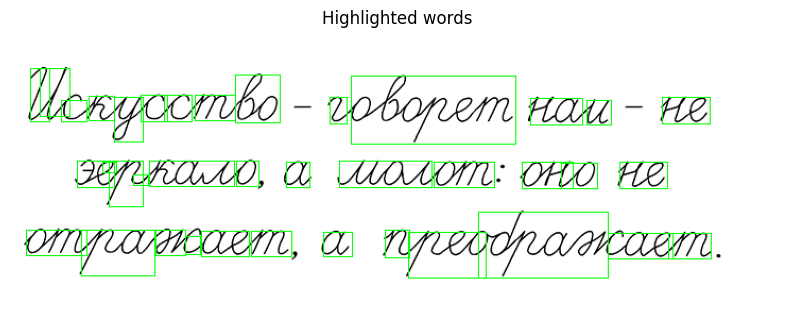

In [6]:
vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for (x, y, w, h) in bboxes:
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.figure(figsize=(10,10))
plt.title("Highlighted words")
plt.imshow(vis[..., ::-1])
plt.axis('off')
plt.show()


In [7]:
def merge_boxes_interval_graph(bboxes, alpha=0.25, y_overlap_thr=0.5, max_iter=4):
    boxes = [list(b) for b in bboxes]
    for _ in range(max_iter):
        boxes.sort(key=lambda b: (b[1], b[0]))
        used = [False]*len(boxes)
        merged = []

        for i in range(len(boxes)):
            if used[i]: 
                continue
            xi, yi, wi, hi = boxes[i]
            x0, y0, x1, y1 = xi, yi, xi+wi, yi+hi
            changed = True
            used[i] = True

            while changed:
                changed = False
                line_h = y1 - y0
                gap_allow = max(2, int(alpha * line_h))
                for j in range(len(boxes)):
                    if used[j]: 
                        continue
                    xj, yj, wj, hj = boxes[j]
                    xa0, ya0, xa1, ya1 = xj, yj, xj+wj, yj+hj

                    inter_y = max(0, min(y1, ya1) - max(y0, ya0))
                    min_h = min(line_h, hj)
                    y_ok = inter_y / max(1, min_h) >= y_overlap_thr

                    x_overlap = not (xa0 > x1 or xa1 < x0)
                    x_touch = (0 <= xa0 - x1 <= gap_allow) or (0 <= x0 - xa1 <= gap_allow)
                    x_ok = x_overlap or x_touch

                    if y_ok and x_ok:
                        x0, y0 = min(x0, xa0), min(y0, ya0)
                        x1, y1 = max(x1, xa1), max(y1, ya1)
                        used[j] = True
                        changed = True

            merged.append((x0, y0, x1 - x0, y1 - y0))

        if len(merged) == len(boxes):
            return merged
        boxes = [list(b) for b in merged]
    return [tuple(b) for b in boxes]

merged_boxes = merge_boxes_interval_graph(bboxes, alpha=0.22, y_overlap_thr=0.5, max_iter=4)
print("After graph merged:", len(merged_boxes))


After graph merged: 11


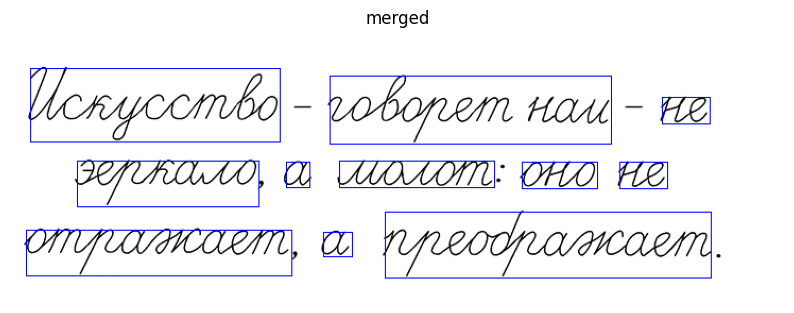

In [8]:
vis_merge = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for (x, y, w, h) in merged_boxes:
    cv2.rectangle(vis_merge, (x, y), (x + w, y + h), (255, 0, 0), 1)

plt.figure(figsize=(10,10))
plt.title("merged")
plt.imshow(vis_merge[..., ::-1])
plt.axis('off')
plt.show()

